## Support Vector Machines (SVM)

In this tutorial, we will cover a more advanced classification algorithm through the use of *Support Vector Machines* (SVMs). The goal is to gain an intuition of how SVMs works and how to use *Gaussian kernel* with SVMs to find out the decision boundary. The implementation proposed here follows a simplified version of the *Sequential Minimal Optimization* (SMO) algorithm for training support vector machines, which is detailed in the following [paper](http://cs229.stanford.edu/materials/smo.pdf). The complete SMO algorithm can then be quite easily implemented following the [full paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf).

Once again, to simplify your work, we provide the following set of functions that you should find in the `data` folder, and in the `helper_plot` file


  |**File**|*Explanation*|
  |-------:|:------------|
  |`svm_linear.mat`|Example data for a quasi-linear problem|
  |`svm_gaussian.mat`|Example data for a non-linear but well-defined problem|
  |`plot_data`|Allows to plot the set of data points|
  |`visualize_boundary`|Plots a non-linear decision boundary from a SVM model|
  |`plot_svc_decision_function`|Plots a linear decision boundary|

In [1]:
import numpy as np
from scipy import io as sio
from matplotlib import pyplot as plt
from helper_plot import plot_data, visualize_boundary, visualize_boundary_linear, hdr_plot_style, plot_svc_decision_function

<a id="motivation"></a>
## Motivation

In the previous course on neural networks, we learned how to train a simple neuron. We saw that this simple model could be interpreted as defining a line, separating the space into two different regions. This allows to consider problems of *discriminative classification*: rather than modeling each class, we simply find a line that divides the classes from each other. As an example of these _linearly separable_ problems, consider the simple case of a classification task, in which the two classes of points are well separated:

Text(0.5, 1.0, 'Linear classification example')

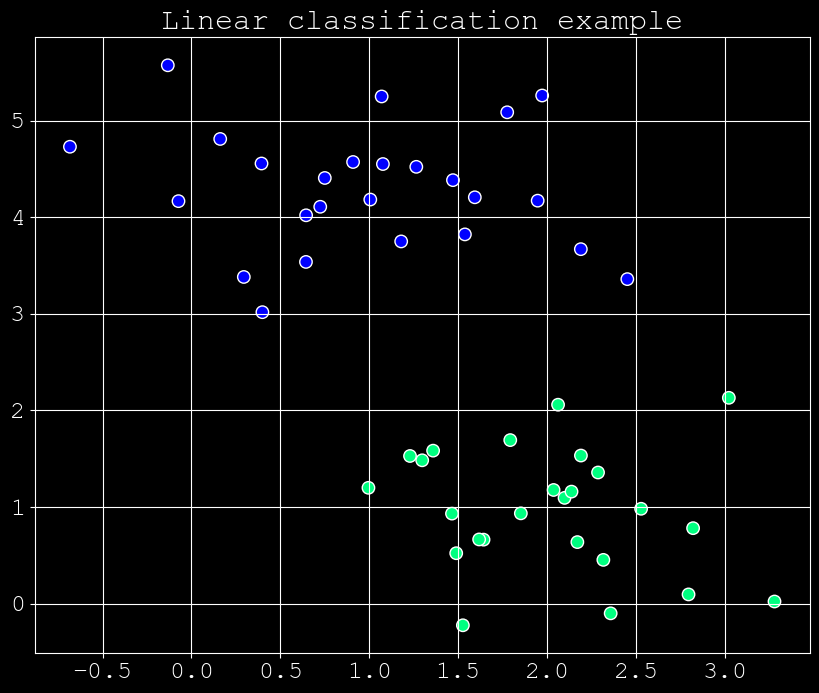

In [2]:
from sklearn.datasets import make_blobs
hdr_plot_style()
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.65)
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolor='w', cmap='winter')
plt.title("Linear classification example")

### Fitting the SVM with scikit-learn

First, we can see the result of fitting this approach to our original data. To do so, we will use the SVM model found in `scikit-learn` to train an SVM model on this data. To do so, we can use the following code

In [3]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

To visualize the results, we will use our quick convenience function that plots the SVM decision boundaries

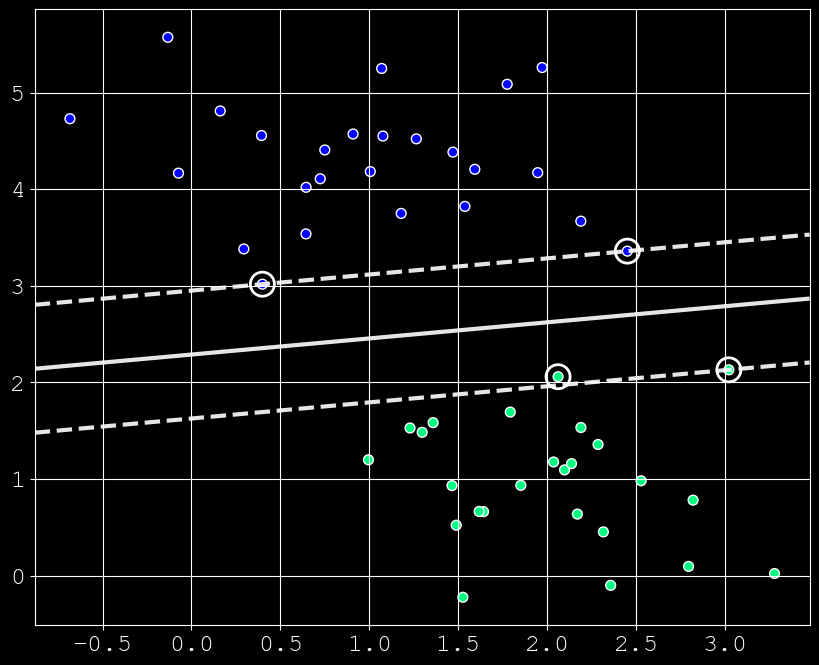

In [4]:
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='w', cmap='winter')
plot_svc_decision_function(model)

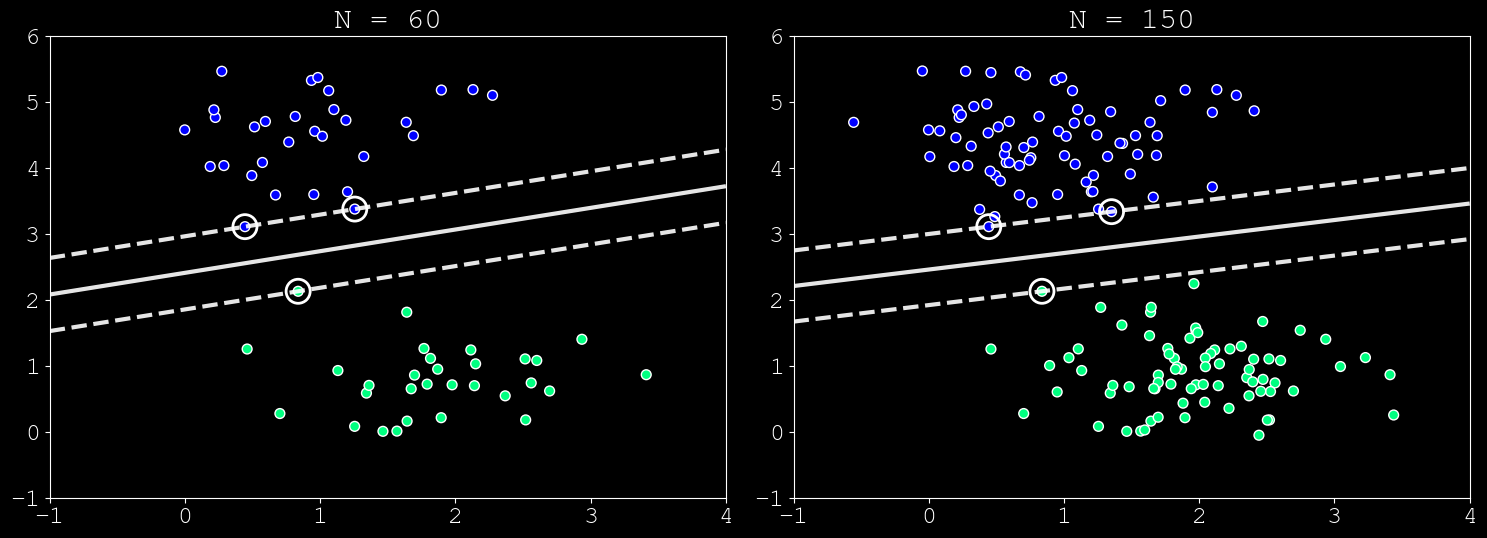

In [5]:
# Plotting SVM trained on subsampled dataset
def plot_svm_subsample(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor = 'w', cmap='winter')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 150]):
    plot_svm_subsample(N, axi)
    axi.set_title('N = {0}'.format(N))

# Beyond linear problems with _kernels_

For the time being, our SVM is only able to solve _linear_ problems. However, the SVM approach becomes truly powerful is when it is combined with *kernels*. As seen in the slides, the major idea is to project our (non-linearly separable) data into a higher-dimensional space, where it becomes linearly separable (allowing to fit for nonlinear relationships with a linear classifier).

To better understand this idea, we can look at the same non linearly separable data that we discussed in the slides. Here, we try to fit a _linear_ SVM to this non-linear problem.

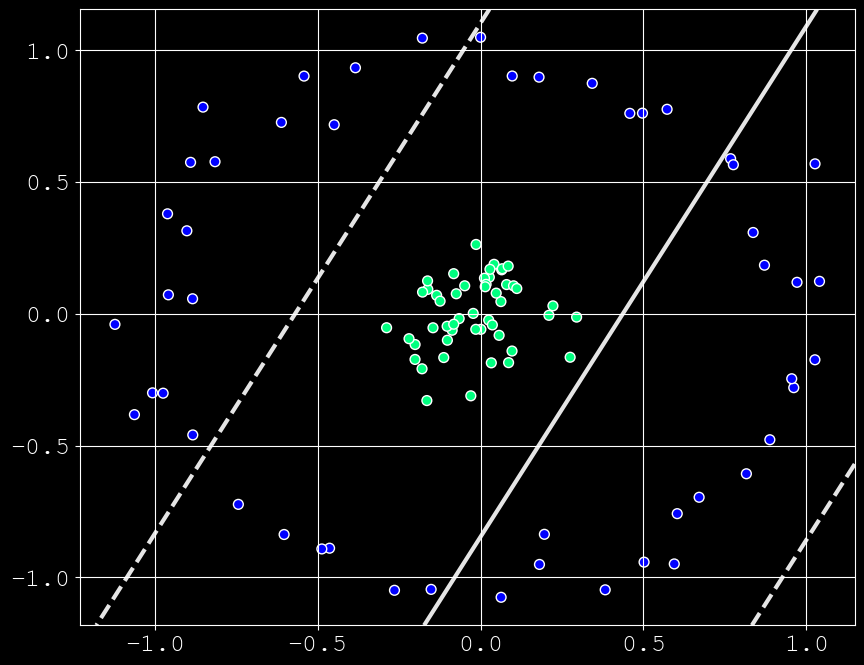

In [6]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='w', cmap='winter')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data. As discussed, we need to think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient. For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle group of points.

In [7]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot

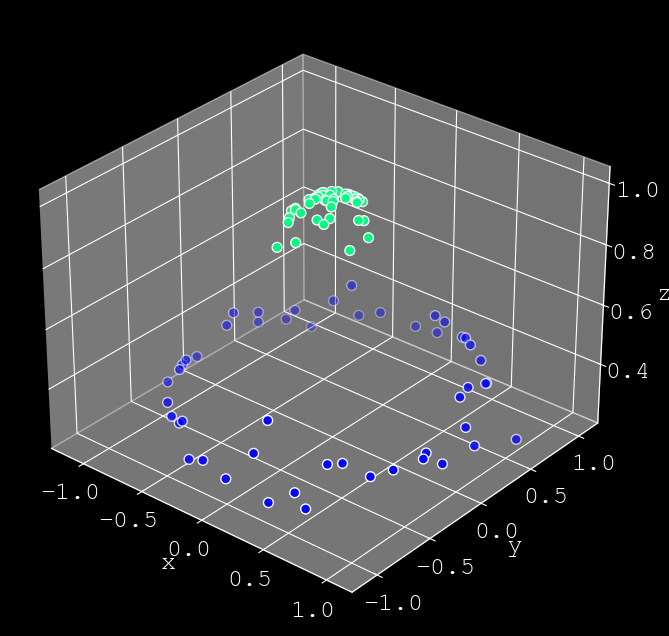

In [8]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    plt.figure(figsize=(10, 8));
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, edgecolor='w', cmap='winter')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
plot_3D(elev=30, azim=-50, X=X, y=y);

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane. Here we had to choose and carefully tune our projection. In general, the need to make such a choice is a problem, as we would like to somehow automatically find the best basis functions to use. One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm find the result. This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between **each pair of points**.

To see this idea in action first, we will (as previously) use `scikit-learn`, where we can apply _kernelized SVM_ simply by changing our _linear kernel_ to an _RBF (radial basis function)_ kernel, using the ``kernel`` model hyperparameter:

In [9]:
model = SVC(kernel='rbf', C=1E6)
model.fit(X, y)

SVC(C=1000000.0)

Once fitted, we can see that our SVM is able to find the largest margin between these two sets of data

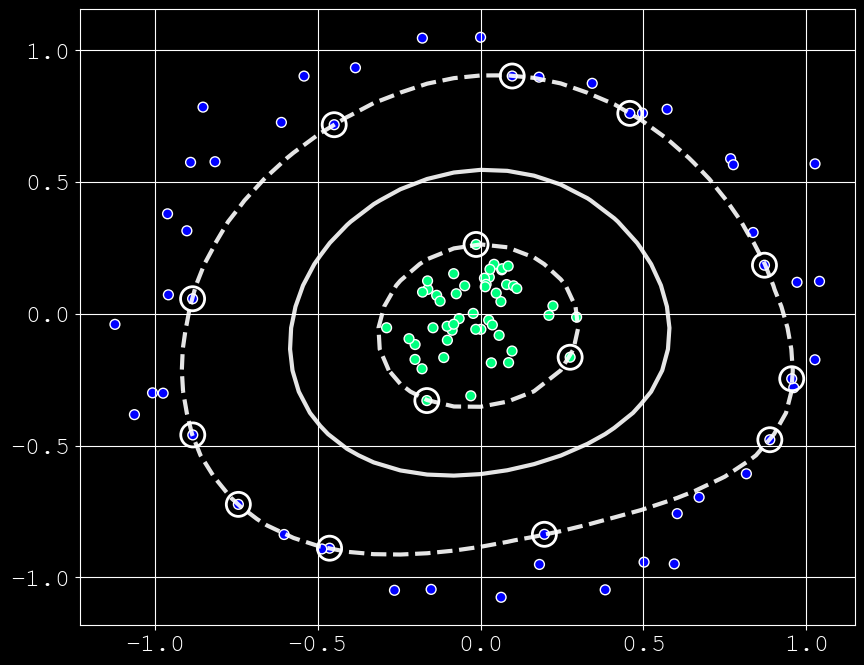

In [10]:
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='w', cmap='winter')
plot_svc_decision_function(model)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

## Audio application

As seen in the previous tutorial, we have considered only a *binary classification* problem (where elements can only belong to one of two classes). This simplifies the work as we simply need to separate the space between two types of points. However, in real-world problems, we usually want to solve *multi-class* problems with any given number of classes. For this tutorial, we will rely on a simple trick which is to consider that a $n$-class problem can simply be restated as $n$ different binary classification problems. The underlying idea is that each class defines a binary classifier which tells us if a given element is part of this class, or belongs to *any of the other* classes.

In [11]:
from helper_data import import_dataset, compute_transforms, compute_features
class_path = 'Data/classification'
# 0.1 - Import the classification dataset
data_struct = import_dataset(class_path, 'classification')
# 0.2 - Pre-process the audio to obtain spectral transforms 
data_struct = compute_transforms(data_struct)
# 0.3 - Compute a set of temporal and spectral features
data_struct = compute_features(data_struct)

    - Importing dataset Data/classification.

    - Performing transforms.
    - Performing features.


In [12]:
data_struct.keys()

dict_keys(['filenames', 'classes', 'class_names', 'signal', 'srate', 'spectrum_power', 'spectrum_mel', 'spectrum_chroma', 'spectrum_CQT', 'features_spectral', 'loudness', 'loudness_mean', 'loudness_std', 'spectral_centroid', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_bandwidth', 'spectral_bandwidth_mean', 'spectral_bandwidth_std', 'spectral_contrast', 'spectral_contrast_mean', 'spectral_contrast_std', 'spectral_flatness', 'spectral_flatness_mean', 'spectral_flatness_std', 'spectral_rolloff', 'spectral_rolloff_mean', 'spectral_rolloff_std'])

In [19]:
labels = ["loudness_mean", "spectral_centroid_mean", "spectral_bandwidth_mean","spectral_contrast_mean", "spectral_flatness_mean", "spectral_rolloff_mean"]
inputs = []
for label in labels :
    inputs.append(data_struct[label]/np.max(np.abs(data_struct[label])))

inputs = np.asarray(inputs)

print(inputs.shape)

(6, 410)


In [20]:
print(inputs)

[[2.52620488e-01 1.51251525e-01 2.83797860e-01 ... 6.01214945e-01
  1.58183113e-01 1.72059804e-01]
 [6.17119854e-01 6.17531047e-01 5.31247838e-01 ... 6.59894596e-01
  7.26974070e-01 4.73696608e-01]
 [6.87462897e-01 6.49056538e-01 6.75745252e-01 ... 7.55909086e-01
  9.26773799e-01 7.98978898e-01]
 [9.82061865e-01 9.53251951e-01 9.04209012e-01 ... 6.82055585e-01
  6.99900905e-01 6.91469462e-01]
 [2.88589690e-02 7.45606348e-02 8.12034309e-02 ... 1.26772383e-02
  2.63538351e-03 5.08551486e-04]
 [6.43704680e-01 6.33564399e-01 5.84096534e-01 ... 7.35748643e-01
  8.51628545e-01 6.27244330e-01]]


In [21]:
from sklearn import linear_model, svm, discriminant_analysis, metrics
from sklearn.model_selection import train_test_split

In [22]:
X = inputs.T
y = data_struct["classes"]
# Diviser les données en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [23]:
clf = svm.SVC(gamma = 0.5,C=1E2, kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=100.0, gamma=0.5)

In [24]:
y = data_struct["class_names"]

class_label = [(data_struct["class_names"][i],i) for i in range(16)]
print(class_label)

[('altotrombone', 0), ('animals', 1), ('bells', 2), ('cellobowed', 3), ('crowds', 4), ('laughter', 5), ('machines', 6), ('oboe', 7), ('percussion', 8), ('speech.female', 9), ('speech.male', 10), ('telephone', 11), ('tubularbells', 12), ('violinbowed', 13), ('violinpizz', 14), ('water', 15)]


In [28]:
%matplotlib ipympl

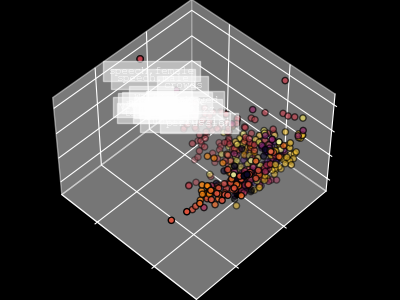

In [32]:
from sklearn import decomposition
from sklearn import datasets

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

np.random.seed(5)

fig = plt.figure(1, figsize=(4, 3))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])


plt.cla()
pca = decomposition.PCA(n_components = 6,svd_solver = 'full')
pca.fit(X)
X_pca = pca.transform(X)

for name, label in [("altotrombone", 0), ("animals", 1), ("bells", 2), ("cellobowed", 3), ("crowds", 4), ("laughter", 5), ("machines", 6), ("oboe", 7), ("percussion", 8), ("speech.female", 9), ("speech.male", 10), ("telephone", 11), ("tubularbells", 12), ("violinbowed", 13), ("violinpizz", 14), ("water", 15)]:
    
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean(),
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
        fontsize = 8,
    )
# Reorder the labels to have colors matching the cluster results
#y = np.choose(y, [1, 2, 0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]).astype(float)
y = data_struct["classes"]
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap="inferno", edgecolor="k") #plt.cm.coolwarm

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.legend(data_struct["class_names"],loc="upper right")
plt.show()


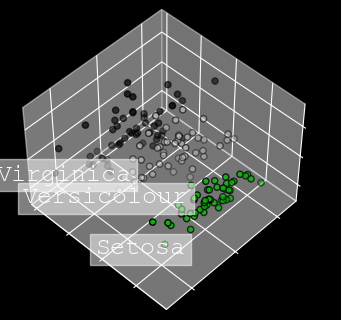

In [93]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn import decomposition
from sklearn import datasets

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

fig = plt.figure(1, figsize=(4, 3))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])


plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()